# Import librairies

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Load data

In [2]:
train_data_rio = pd.read_csv('station_rio.csv')

In [3]:
train_data_rio.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,27.45,24.87,21.98,22.33,24.16
1,1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54,26.56,24.42,21.24,23.41,23.91
2,1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53,25.58,23.54,21.05,23.05,23.31
3,1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56,26.74,24.18,20.82,22.58,23.58
4,1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84,27.07,24.48,22.50,23.61,24.42


In [4]:
train_data_rio.shape

(47, 18)

In [5]:
train_data_rio = pd.read_csv('station_rio.csv')

In [6]:
train_data_rio.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,27.45,24.87,21.98,22.33,24.16
1,1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54,26.56,24.42,21.24,23.41,23.91
2,1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53,25.58,23.54,21.05,23.05,23.31
3,1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56,26.74,24.18,20.82,22.58,23.58
4,1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84,27.07,24.48,22.50,23.61,24.42


In [7]:
train_data_rio.shape

(47, 18)

# Pré-processamento dos dados

In [8]:
months_dict = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6, 'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}

train_data_rio = train_data_rio[['YEAR'] + list(months_dict.keys())]
train_data_rio.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85
1,1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54
2,1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53
3,1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56
4,1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84


In [9]:
df_rio = pd.melt(train_data_rio, 
        id_vars='YEAR',
        value_vars=months_dict.keys(),
        var_name='MONTH', 
        value_name='Sum of Value').replace({"MONTH": months_dict}) # replaces month names to month numbers.

df_rio.head()

,YEAR,MONTH,Sum of Value
0,1973,1,27.73
1,1974,1,26.68
2,1975,1,25.27
3,1976,1,27.48
4,1977,1,27.13


In [10]:
df_rio["DAY"] = 1
df_rio['DATE'] = pd.to_datetime(df_rio[['YEAR','MONTH','DAY']])
df_rio = df_rio.rename(columns = {'Sum of Value':'TEMP'})
df_rio = df_rio.sort_values("DATE").reset_index(drop=True)

df_rio = df_rio.drop(["YEAR", "MONTH", "DAY"], axis = 1)
df_rio = df_rio.set_index('DATE', drop = True)

In [11]:
df_rio.head()

,TEMP
DATE,
1973-01-01,27.73
1973-02-01,27.97
1973-03-01,25.70
1973-04-01,26.49
1973-05-01,22.42


In [12]:
df_rio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 564 entries, 1973-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    564 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB


## _Interpolate Data
Há dados faltantes, esta parte do código é para cobrir estes dados por interpolação

In [13]:
print(df_rio["TEMP"].min(), df_rio["TEMP"].max(), df_rio["TEMP"].mean())

19.24 999.9 105.56517730496454


In [14]:
df_rio.replace(999.90, np.nan, inplace = True)
df_rio_intp = df_rio.interpolate()

In [15]:
print(df_rio_intp["TEMP"].min(), df_rio_intp["TEMP"].max(), df_rio_intp["TEMP"].mean())

19.24 30.25 24.390939716312058


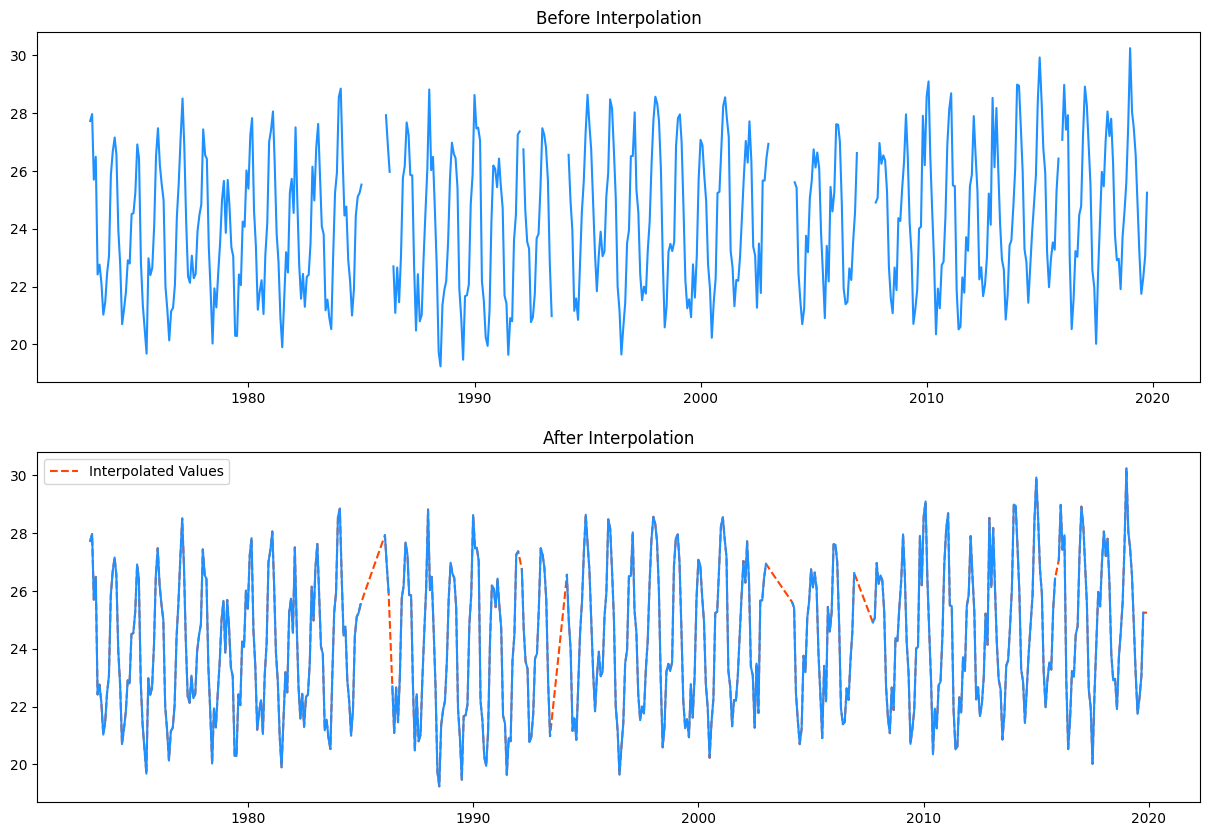

In [16]:
rows = 2
cols = 1

fig, axs = plt.subplots(2, figsize = (15, 10))

axs[0]
axs[0].set_title('Before Interpolation')
axs[0].plot(df_rio, color = 'dodgerblue')

axs[1].plot(df_rio_intp, color = 'orangered', linestyle = '--', label = 'Interpolated Values')
legend = plt.legend(loc = 'upper left')
axs[1].set_title("After Interpolation")
axs[1].plot(df_rio, color = 'dodgerblue')

plt.show()

## _Scaling - Aqui está padronizando os dados

In [17]:
temp = df_rio_intp.filter(["TEMP"])
temp_values = temp.values

In [18]:
# scaler = MinMaxScaler(feature_range = (0,1))
# scaled_data = scaler.fit_transform(temp_values)

In [19]:
scaled_data = temp_values

In [20]:
scaled_data.shape

(564, 1)

In [21]:
scaled_data[:5]

array([[27.73],
       [27.97],
       [25.7 ],
       [26.49],
       [22.42]])

In [22]:
df_rio_intp.head(5)

,TEMP
DATE,
1973-01-01,27.73
1973-02-01,27.97
1973-03-01,25.70
1973-04-01,26.49
1973-05-01,22.42


# Train test split

In [23]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [24]:
# Total de dados
total_data_len = len(scaled_data)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)


564
394
84


In [25]:
# Criando conjuntos de treinamento
train_data = scaled_data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

334
334
394


In [26]:
# Criando o conjunto de validação
valid_data = scaled_data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

24
24
84


In [27]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = scaled_data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = temp_values[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

86
86
146


In [28]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'y_valid length: {len(y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 334
Y_train length: 334
X_valid length: 24
y_valid length: 24
X_test length: 86
Y_test length: 86


# Decomposição da Série

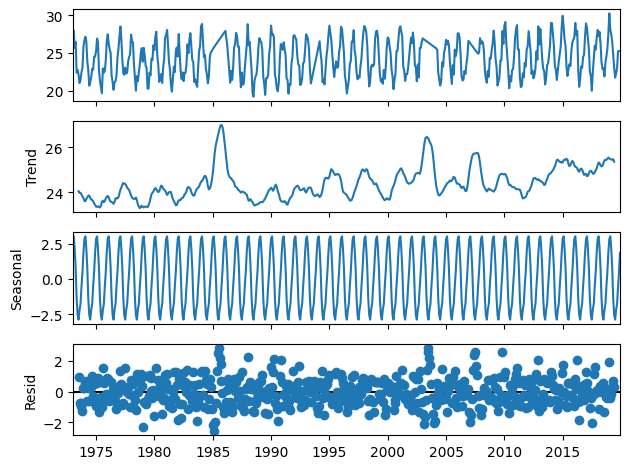

In [29]:
# Additive model
res = sm.tsa.seasonal_decompose(df_rio_intp,period=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [30]:
# Stationarity tests
def test_stationarity(df_rio_intp):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df_rio_intp, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_rio_intp)

Results of Dickey-Fuller Test:
Test Statistic                  -5.174339
p-value                          0.000010
#Lags Used                      15.000000
Number of Observations Used    548.000000
Critical Value (1%)             -3.442339
Critical Value (5%)             -2.866829
Critical Value (10%)            -2.569587
dtype: float64


# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [31]:
epochs = 10
batch = 32
lr = 0.001
adam = optimizers.Adam(lr)

In [32]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=adam)
model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
mlp_history = model_mlp.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/10
11/11 - 2s - 187ms/step - loss: 981.9131 - val_loss: 604.0705
Epoch 2/10
11/11 - 0s - 13ms/step - loss: 185.9748 - val_loss: 70.8607
Epoch 3/10
11/11 - 0s - 8ms/step - loss: 81.0356 - val_loss: 7.9937
Epoch 4/10
11/11 - 0s - 16ms/step - loss: 21.7685 - val_loss: 22.7429
Epoch 5/10
11/11 - 0s - 8ms/step - loss: 9.9791 - val_loss: 10.1244
Epoch 6/10
11/11 - 0s - 8ms/step - loss: 9.0515 - val_loss: 10.8295
Epoch 7/10
11/11 - 0s - 6ms/step - loss: 7.1373 - val_loss: 6.9253
Epoch 8/10
11/11 - 0s - 11ms/step - loss: 6.5655 - val_loss: 7.2579
Epoch 9/10
11/11 - 0s - 7ms/step - loss: 6.0385 - val_loss: 6.6646
Epoch 10/10
11/11 - 0s - 7ms/step - loss: 5.6968 - val_loss: 6.3629


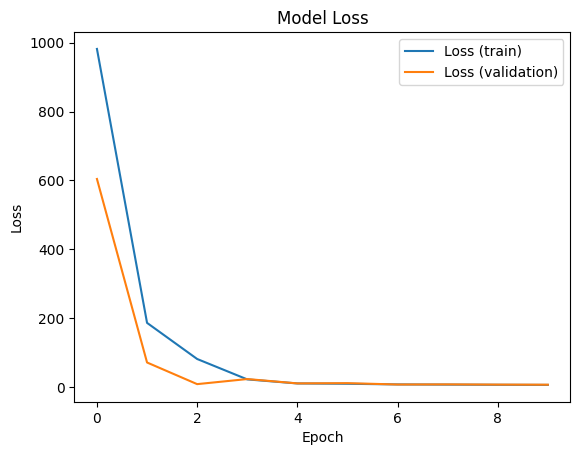

In [34]:

plt.plot(mlp_history.history['loss'], label='Loss (train)')
plt.plot(mlp_history.history['val_loss'], label='Loss (validation)')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [35]:
model_reg = Sequential()
model_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1], 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_reg.add(Dense(32, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_reg.add(Dense(1))  # Saída
model_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
model_reg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
mlp_reg_history = model_reg.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/10
11/11 - 2s - 141ms/step - loss: 230.6146 - val_loss: 84.7773
Epoch 2/10
11/11 - 0s - 7ms/step - loss: 36.9987 - val_loss: 11.7276
Epoch 3/10
11/11 - 0s - 7ms/step - loss: 15.8899 - val_loss: 9.4698
Epoch 4/10
11/11 - 0s - 7ms/step - loss: 10.1358 - val_loss: 9.9351
Epoch 5/10
11/11 - 0s - 7ms/step - loss: 7.9677 - val_loss: 6.4697
Epoch 6/10
11/11 - 0s - 7ms/step - loss: 5.1257 - val_loss: 4.4597
Epoch 7/10
11/11 - 0s - 6ms/step - loss: 4.2791 - val_loss: 3.8998
Epoch 8/10
11/11 - 0s - 7ms/step - loss: 3.7814 - val_loss: 3.6168
Epoch 9/10
11/11 - 0s - 8ms/step - loss: 3.3584 - val_loss: 2.9238
Epoch 10/10
11/11 - 0s - 12ms/step - loss: 3.0617 - val_loss: 2.6547


In [37]:
model_dropout = Sequential()
model_dropout.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_dropout.add(Dropout(0.5))  # 50% de dropout
model_dropout.add(Dense(32, activation='relu'))
model_dropout.add(Dropout(0.5))  # 50% de dropout
model_dropout.add(Dense(1))  # Saída
model_dropout.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
model_dropout.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
mlp_drop_history = model_dropout.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/10
11/11 - 2s - 147ms/step - loss: 1218.8469 - val_loss: 108.2151
Epoch 2/10
11/11 - 0s - 7ms/step - loss: 561.0822 - val_loss: 64.5415
Epoch 3/10
11/11 - 0s - 7ms/step - loss: 275.5646 - val_loss: 164.8255
Epoch 4/10
11/11 - 0s - 7ms/step - loss: 226.2668 - val_loss: 107.0542
Epoch 5/10
11/11 - 0s - 7ms/step - loss: 150.0403 - val_loss: 69.5741
Epoch 6/10
11/11 - 0s - 7ms/step - loss: 150.0750 - val_loss: 88.3666
Epoch 7/10
11/11 - 0s - 18ms/step - loss: 145.0690 - val_loss: 75.7730
Epoch 8/10
11/11 - 0s - 6ms/step - loss: 135.9035 - val_loss: 72.7818
Epoch 9/10
11/11 - 0s - 8ms/step - loss: 131.0304 - val_loss: 91.5883
Epoch 10/10
11/11 - 0s - 7ms/step - loss: 127.3363 - val_loss: 69.6528


# Comparando os 3 modelos (Testando)

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)
    
    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    
    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    return mae, mse, rmse

# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg = evaluate_model(model_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout = evaluate_model(model_dropout, X_test, Y_test, "Modelo com Dropout")

# Comparação dos resultados (opcional)
print("\nComparação de resultados:")
print(f"Modelo Padrão - MAE: {mae_standard:.4f}, RMSE: {rmse_standard:.4f}")
print(f"Modelo com Regularização - MAE: {mae_reg:.4f}, RMSE: {rmse_reg:.4f}")
print(f"Modelo com Dropout - MAE: {mae_dropout:.4f}, RMSE: {rmse_dropout:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Modelo Padrão:
MAE: 1.9671
MSE: 5.7506
RMSE: 2.3980
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Modelo com Regularização:
MAE: 1.0325
MSE: 1.7959
RMSE: 1.3401
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002FCE617DEE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Model

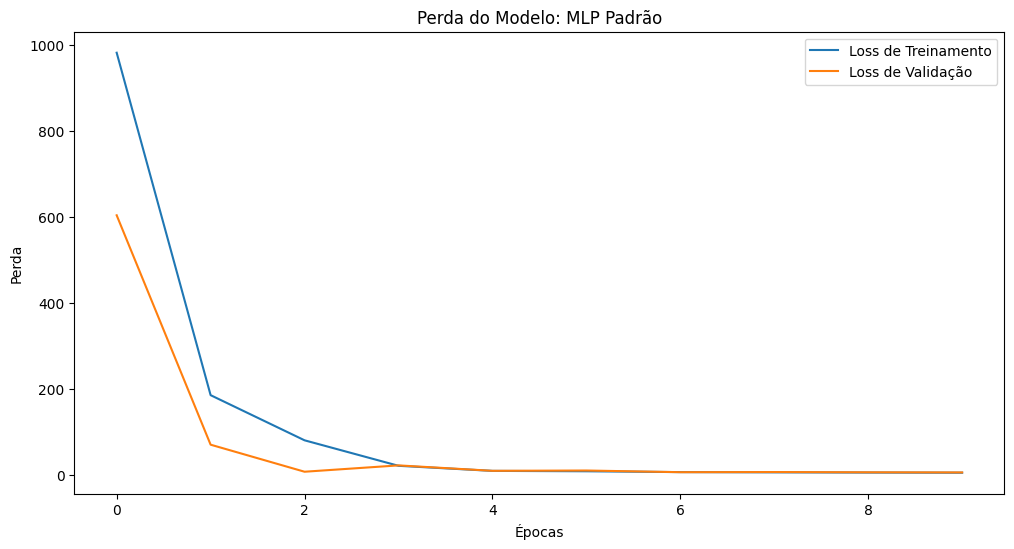

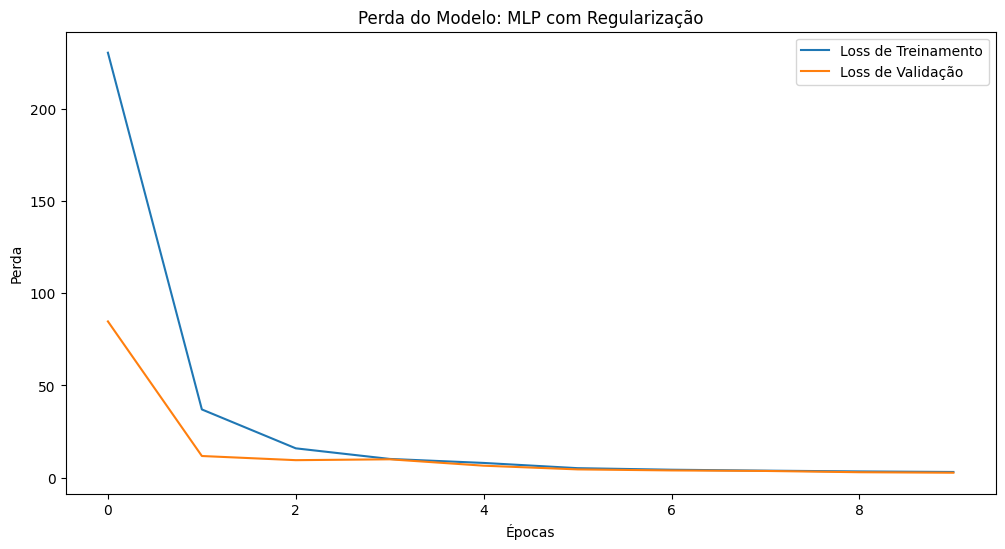

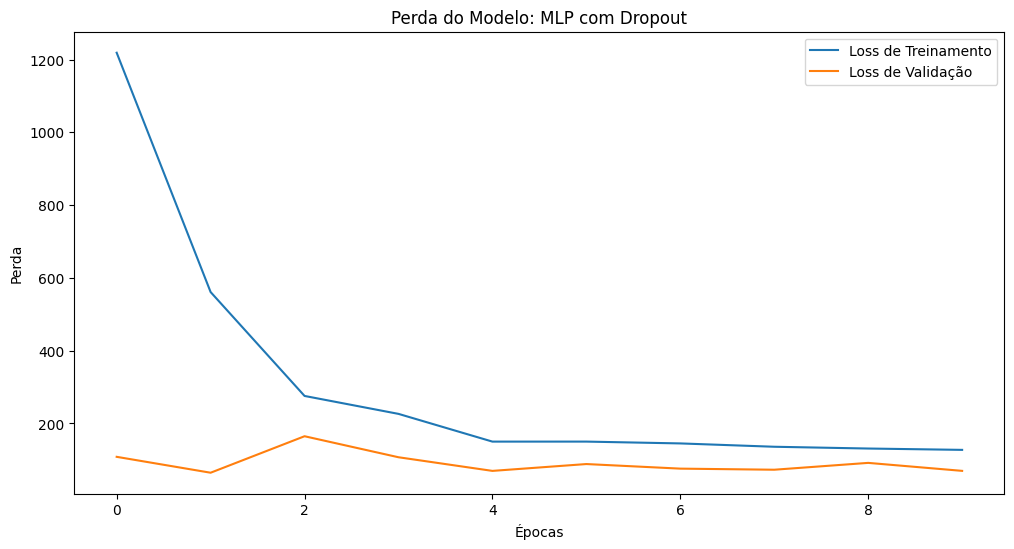

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


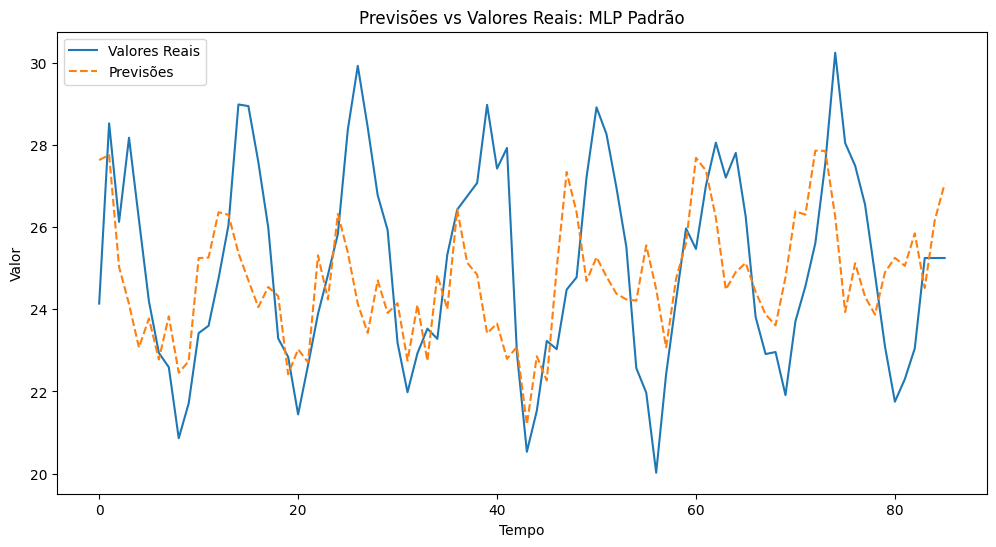

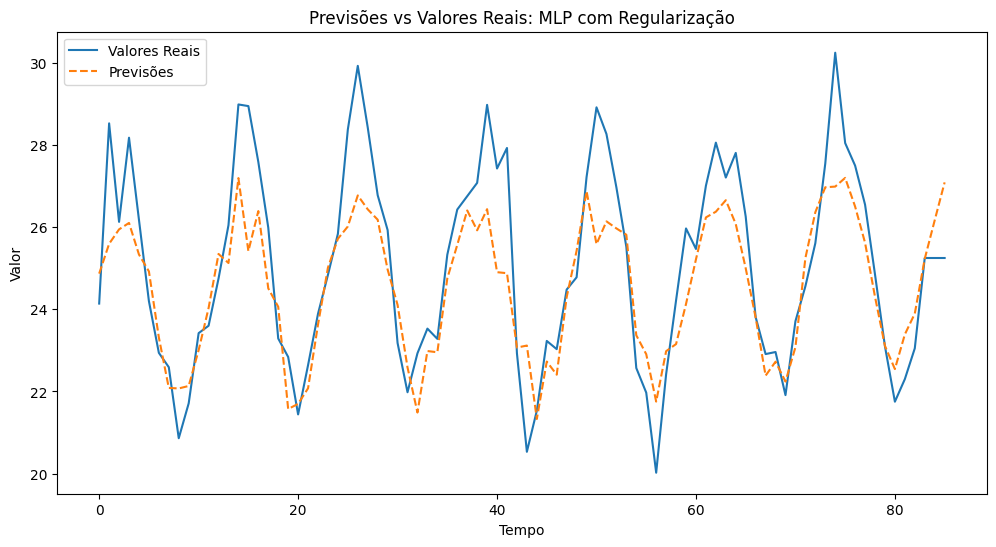

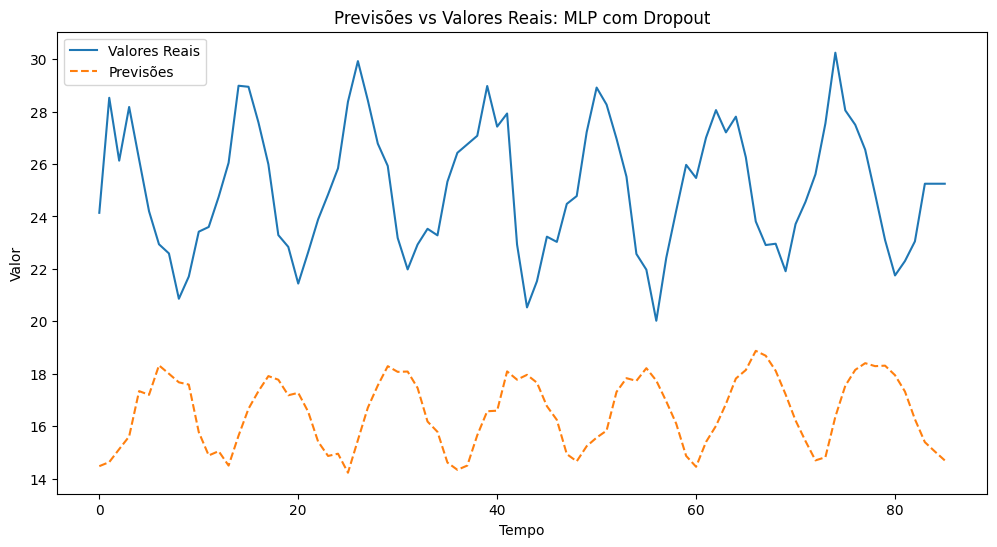

In [41]:
# Gráfico do ajuste do modelo
def plot_loss(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Loss de Treinamento')
    plt.plot(history.history['val_loss'], label='Loss de Validação')
    plt.title(f'Perda do Modelo: {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()

# Plotando as perdas dos três modelos
plot_loss(mlp_history, 'MLP Padrão')
plot_loss(mlp_reg_history, 'MLP com Regularização')
plot_loss(mlp_drop_history, 'MLP com Dropout')

# Gráfico da previsão
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Valores Reais')
    plt.plot(y_pred, label='Previsões', linestyle='--')
    plt.title(f'Previsões vs Valores Reais: {model_name}')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

# Fazendo previsões no conjunto de teste
y_pred_mlp = model_mlp.predict(X_test)
y_pred_reg = model_reg.predict(X_test)
y_pred_drop = model_dropout.predict(X_test)

# Plotando as previsões
plot_predictions(Y_test, y_pred_mlp, 'MLP Padrão')
plot_predictions(Y_test, y_pred_reg, 'MLP com Regularização')
plot_predictions(Y_test, y_pred_drop, 'MLP com Dropout')

# # Revertendo a padronização das previsões
# y_pred_mlp_inverse = scaler.inverse_transform(y_pred_mlp)
# y_pred_reg_inverse = scaler.inverse_transform(y_pred_reg)
# y_pred_drop_inverse = scaler.inverse_transform(y_pred_drop)


# # Plotando as previsões
# plot_predictions(Y_test, y_pred_mlp_inverse, 'MLP Padrão')
# plot_predictions(Y_test, y_pred_reg_inverse, 'MLP com Regularização')
# plot_predictions(Y_test, y_pred_drop_inverse, 'MLP com Dropout')


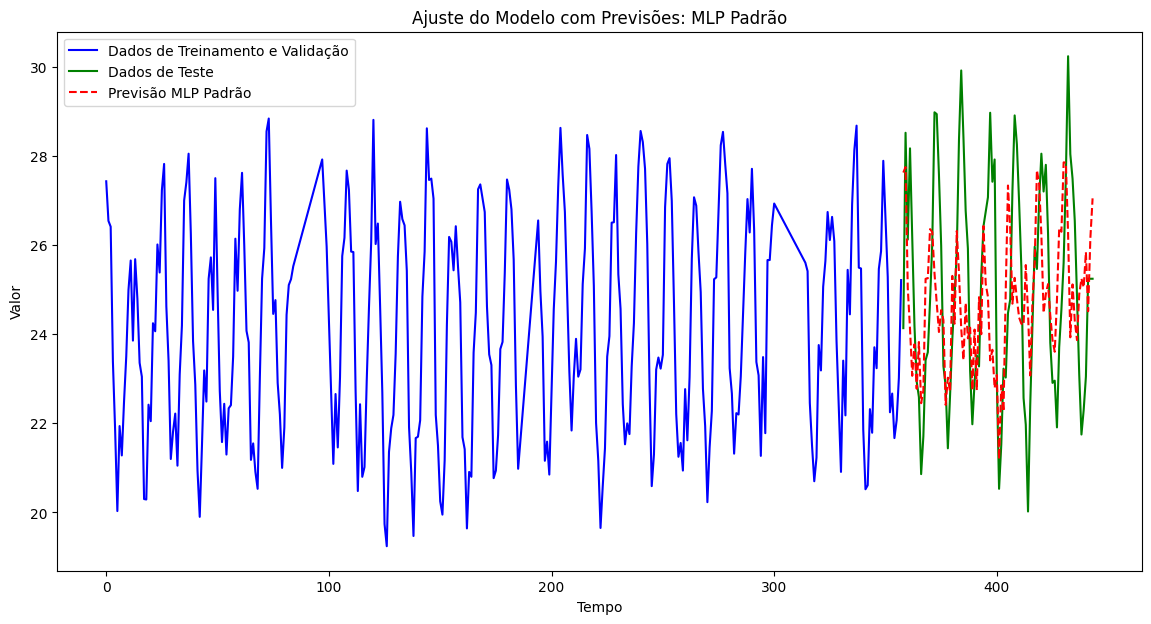

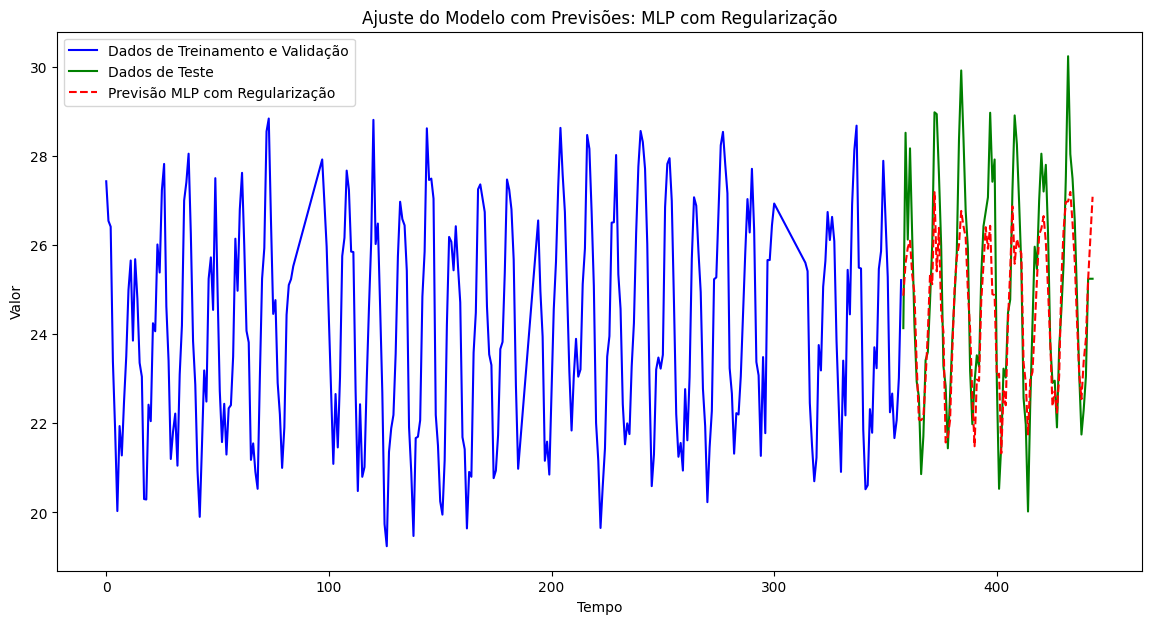

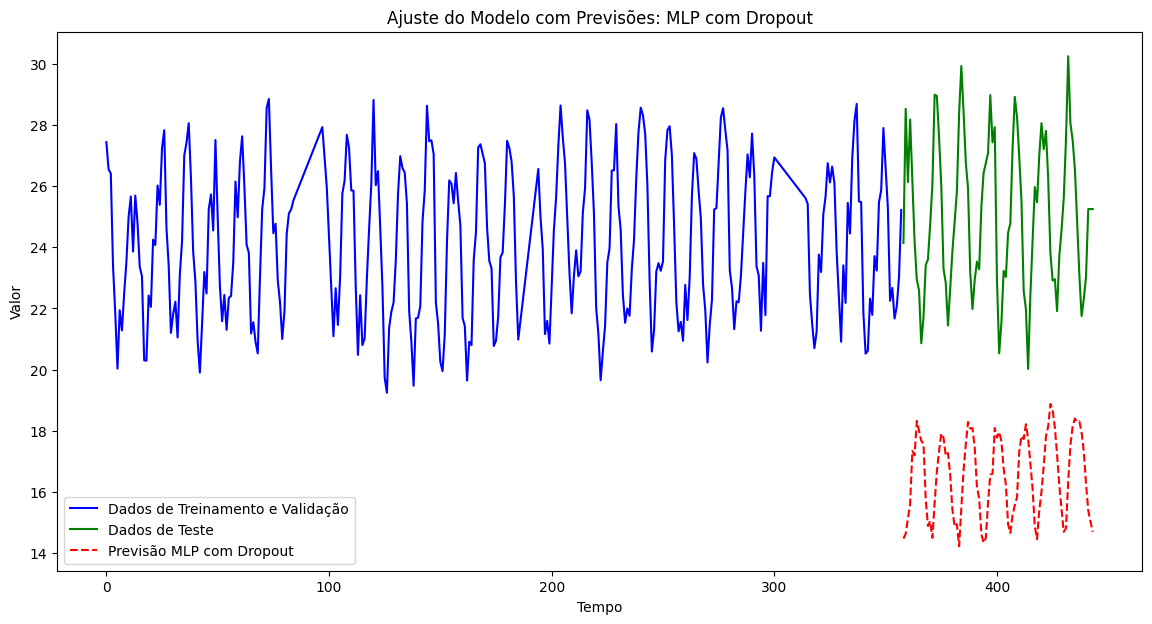

In [42]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

def plot_fit_with_predictions(train_valid_data, y_test, y_pred, model_name):
    plt.figure(figsize=(14, 7))
    
    # Plot dos dados de treino e validação
    plt.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
    
    # Plot dos dados de teste
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
    
    # Plot das previsões
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
    
    plt.title(f"Ajuste do Modelo com Previsões: {model_name}")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

# Plot do ajuste e previsão para cada modelo
plot_fit_with_predictions(train_valid_data, Y_test, y_pred_mlp, "MLP Padrão")
plot_fit_with_predictions(train_valid_data, Y_test, y_pred_reg, "MLP com Regularização")
plot_fit_with_predictions(train_valid_data, Y_test, y_pred_drop, "MLP com Dropout")

### CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)